<a href="https://colab.research.google.com/github/serjisa/transcriptomics.msu/blob/main/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80%D1%8B/10_%D0%9A%D0%BE%D1%80%D1%80%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_%D0%B1%D0%B0%D1%82%D1%87_%D1%8D%D1%84%D1%84%D0%B5%D0%BA%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 10. Коррекция батч-эффекта



## Домашнее задание

Придумайте метрику контроля качества для смешения батчей без использования априорного знания о типе клетки. Провалидируйте вашу метрику на датасетах, с которыми мы работали сегодня.

In [ ]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

import rpy2.robjects as ro
import anndata2ri

ro.numpy2ri.activate()
anndata2ri.activate()  

# Импортируем нужные библиотеки
import scanpy as sc
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Методы батч-коррекции
import bbknn
import scanorama
import harmonypy

# rpy2 и anndata2ri
import anndata2ri
import rpy2

In [9]:
adata = sc.read_h5ad("PBMC_Satija.h5ad")
adata.layers["counts"] = adata.X.copy()

Зададим несколько объектов AnnData, чтобы сравнивать метрику

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/silenos/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)


2022-12-10 12:03:15,104 - harmonypy - INFO - Iteration 1 of 20
2022-12-10 12:03:18,875 - harmonypy - INFO - Iteration 2 of 20
2022-12-10 12:03:22,489 - harmonypy - INFO - Iteration 3 of 20
2022-12-10 12:03:25,852 - harmonypy - INFO - Iteration 4 of 20
2022-12-10 12:03:29,446 - harmonypy - INFO - Iteration 5 of 20
2022-12-10 12:03:32,401 - harmonypy - INFO - Converged after 5 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


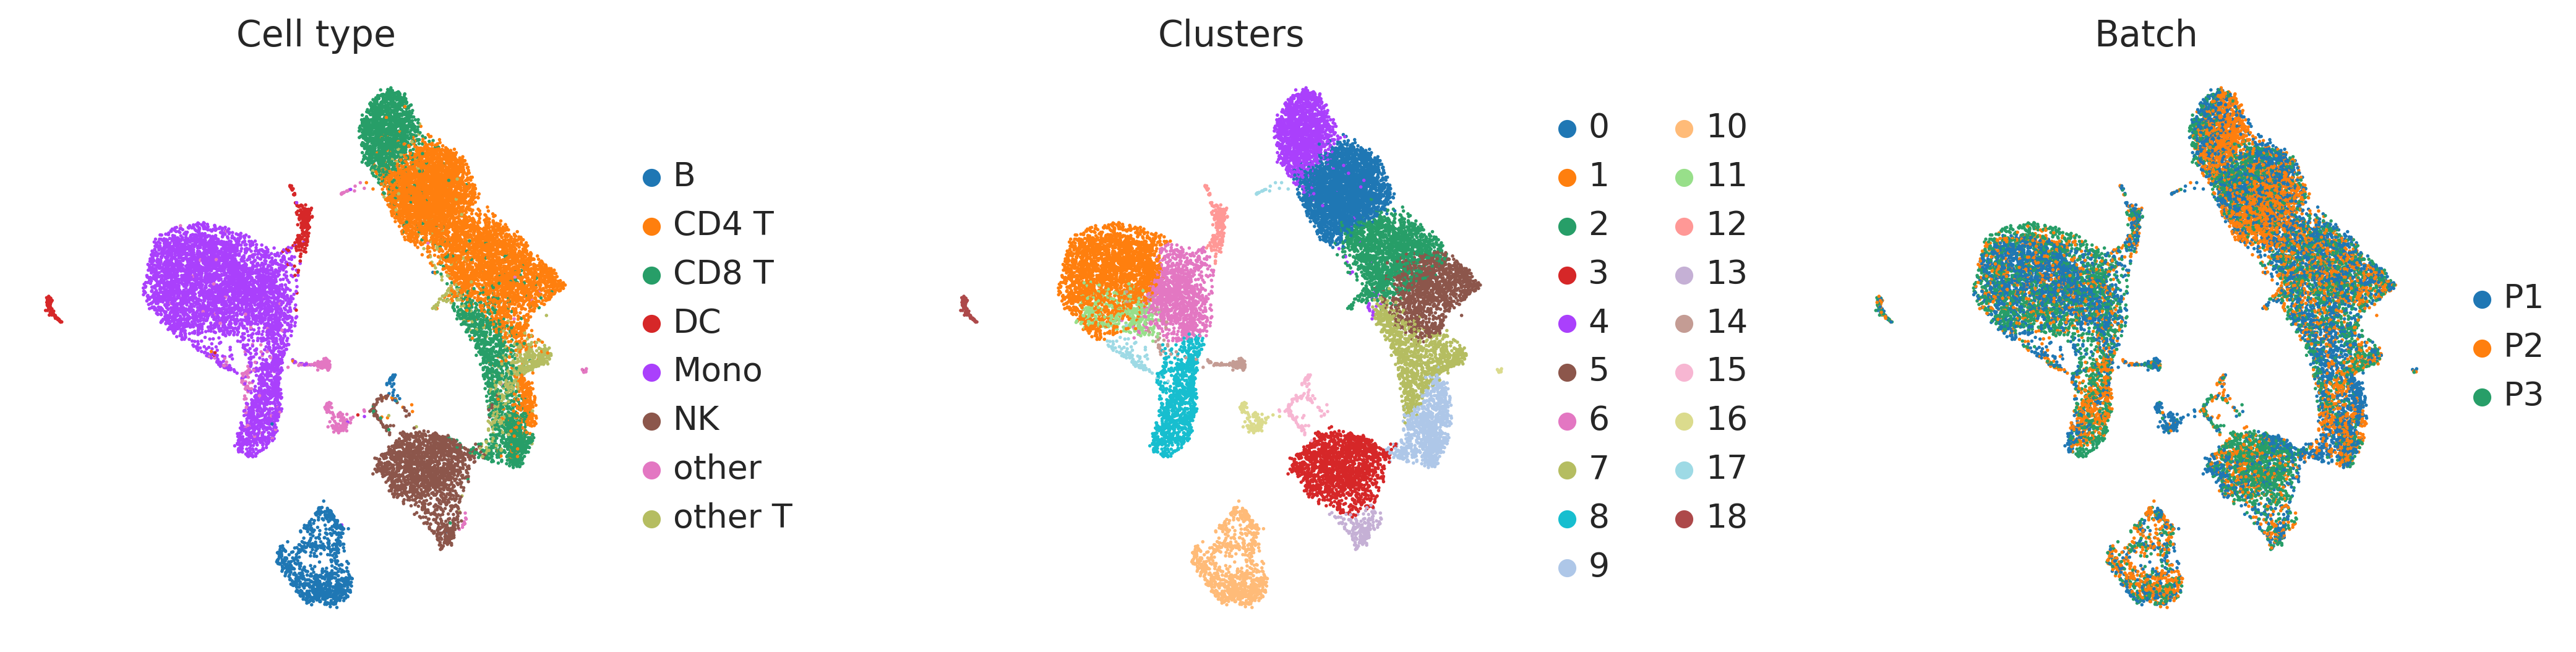

In [89]:
adata_harmony = adata.copy()

sc.pp.normalize_total(adata_harmony)
sc.pp.log1p(adata_harmony)

sc.pp.highly_variable_genes(
    adata_harmony,
    n_top_genes=3000,
    flavor="seurat_v3",
    layer="counts",
    batch_key="donor"
)
adata_harmony.raw = adata_harmony
adata_harmony = adata_harmony[:, adata_harmony.var.highly_variable]

sc.pp.scale(adata_harmony)
sc.tl.pca(adata_harmony)

sc.external.pp.harmony_integrate(adata_harmony, key="donor", max_iter_harmony=20)
# `theta` отвечает за силу интеграции
# `max_iter_harmony` отвечает за максимальное число итераций до тех пор, пока алгоритм не сойдётся

sc.pp.neighbors(
    adata_harmony,
    use_rep="X_pca_harmony",
    n_pcs=30
)

sc.tl.leiden(adata_harmony)
sc.tl.umap(adata_harmony)
sc.pl.umap(adata_harmony, color=["celltype.l1", "leiden", "donor"],
           title=["Cell type", "Clusters", "Batch"], wspace=0.4, frameon=False)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/silenos/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


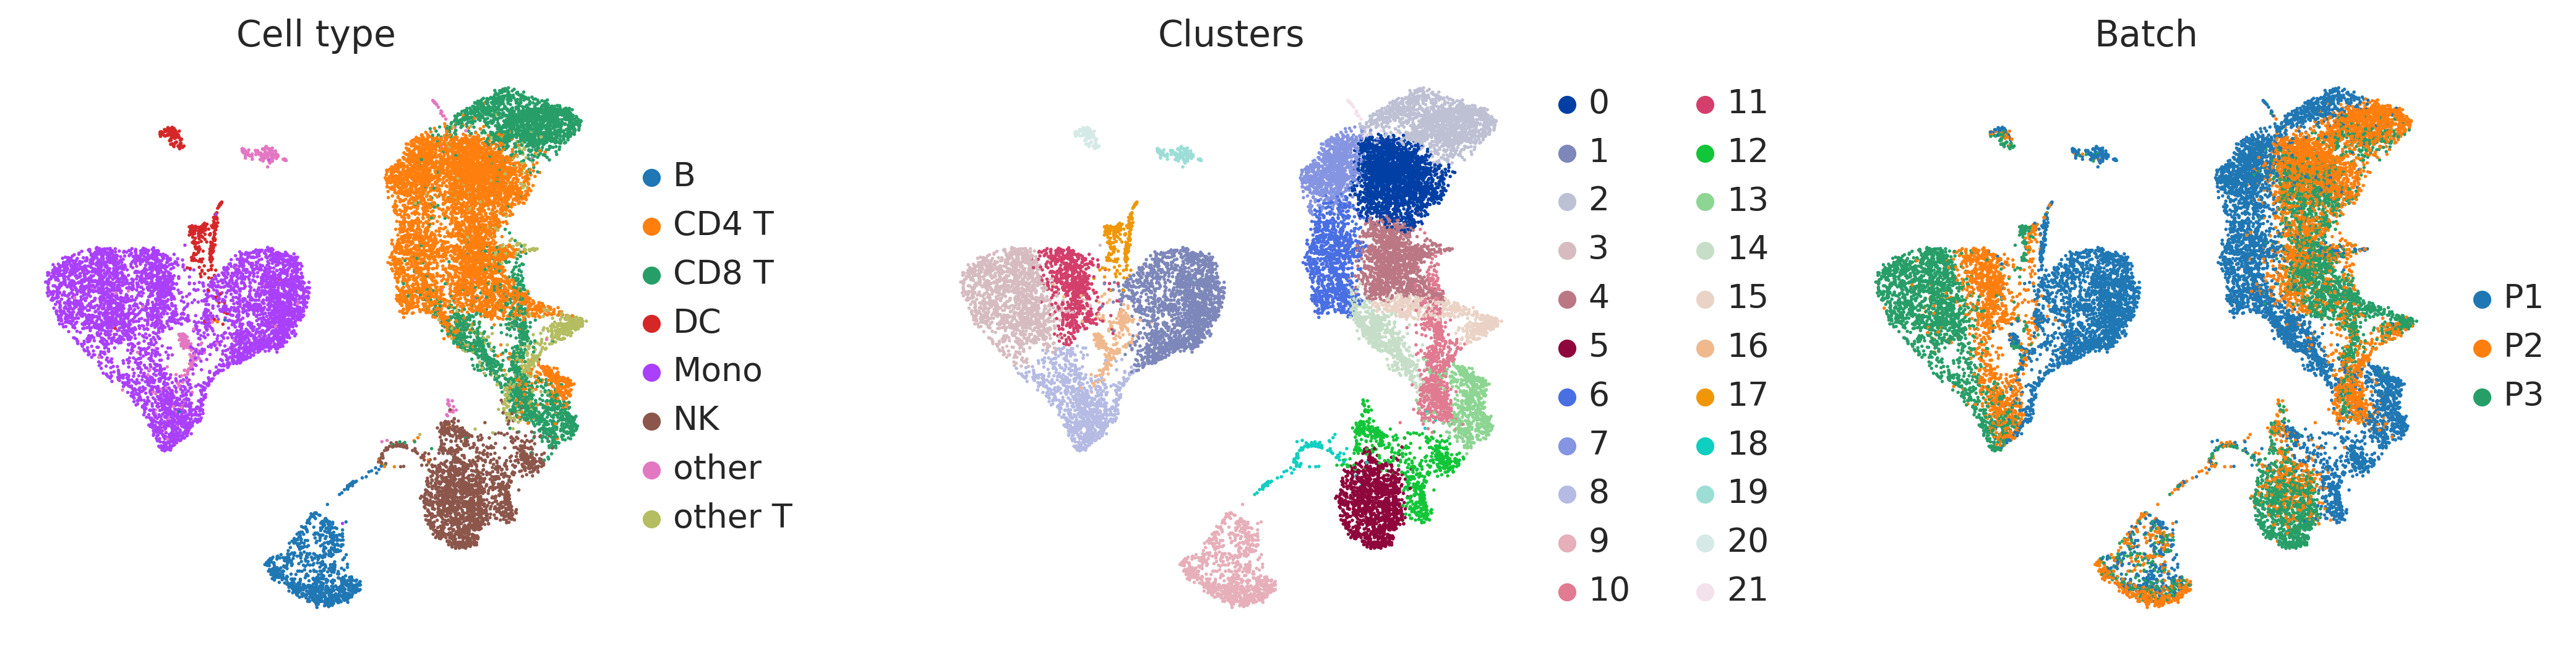

In [88]:
adata_nocorr = adata.copy()

# контроль за дисперсией
sc.pp.normalize_total(adata_nocorr) 
sc.pp.log1p(adata_nocorr)

# выделение HVG сразу на всех батчах
sc.pp.highly_variable_genes(
    adata_nocorr,
    n_top_genes=3000,
    flavor="seurat_v3",
    layer="counts"
)

# оставим только высоковариабельные гены
adata_nocorr.raw = adata_nocorr
adata_nocorr = adata_nocorr[:, adata_nocorr.var.highly_variable]

# шкалирование + PCA
sc.pp.scale(adata_nocorr)
sc.tl.pca(adata_nocorr)

# Граф ближайших соседей knn, где попарные расстояния точек (для юмапа)
sc.pp.neighbors(
    adata_nocorr,
    n_pcs=30,
    n_neighbors=20,
    knn=True
)

# кластеризация
sc.tl.leiden(adata_nocorr)

# umap
sc.tl.umap(adata_nocorr)

sc.pl.umap(adata_nocorr, color=["celltype.l1", "leiden", "donor"],
           title=["Cell type", "Clusters", "Batch"], wspace=0.4, frameon=False)

Я решил создать простую, но все же достаточно показательную метрику, которая подразумевает, что все батчи в идеале должны составлять третью часть кластера. Считая сумму отклонений наблюдаемой доли батча в кластере от "идеальной" доли (33.3%), взятую в модуль, мы получаем сумму отклонений для кластера. Чтобы получить loss metric для всех кластеров, я усредняю ошибку по всем кластерам сразу.

In [98]:
def loss_metric(adata, cluster_key, batch_key):
    
    sizes = adata.obs.groupby([batch_key, cluster_key]).size()
    props = sizes.groupby(level=1).apply(lambda x: 100 * x / x.sum()).reset_index()
    props = props.pivot(columns=cluster_key, index=batch_key).T
    
    # метрика
    metrics = props.assign(metric=lambda x: np.abs(x['P1'] - 33.3) + np.abs(x['P2'] - 33.3) + np.abs(x['P3']) - 33.3)
    print("Batch correlation loss metric:", metrics["metric"].mean())

In [97]:
def barplot(adata, cluster_key, batch_key):
    """
    This function creates a barplot with the distribution of cells
    from different batches across clusters.
    
    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    cluster_key : str
        Name of column in `adata.obs` that corresponds to the name of clusterind.
    batch_key : str
        Name of column in `adata.obs` that corresponds to the name of samples / batches.

    Returns
    ----------
    None.
    """
    
    import matplotlib.pyplot as plt
    import seaborn
    
    fig_width = len(adata.obs[cluster_key].cat.categories) * 0.3
    fig, ax = plt.subplots(dpi=150, figsize=(fig_width, 2))
    
    colors = dict(zip(adata.obs[batch_key].cat.categories,
                      adata.uns[f"{batch_key}_colors"]))
    
    sizes = adata.obs.groupby([batch_key, cluster_key]).size()
    props = sizes.groupby(level=1).apply(lambda x: 100 * x / x.sum()).reset_index()
    props = props.pivot(columns=cluster_key, index=batch_key).T
    
    # помещаем метрику в барплот
    loss_metric(adata, cluster_key, batch_key)
    
    props.index = props.index.droplevel(0)
    props.fillna(0, inplace=True)
    props.plot.bar(stacked=True, width=1,
                   edgecolor="black", ax=ax, color=colors)
    plt.xticks(rotation=90)
    ax.set_xlabel("")
    ax.legend(loc=(1.01, 0.45), edgecolor="white")

Я поместил функцию в барплот, чтобы была наглядность + цифры :)

Batch correlation loss metric: 48.98254577535556


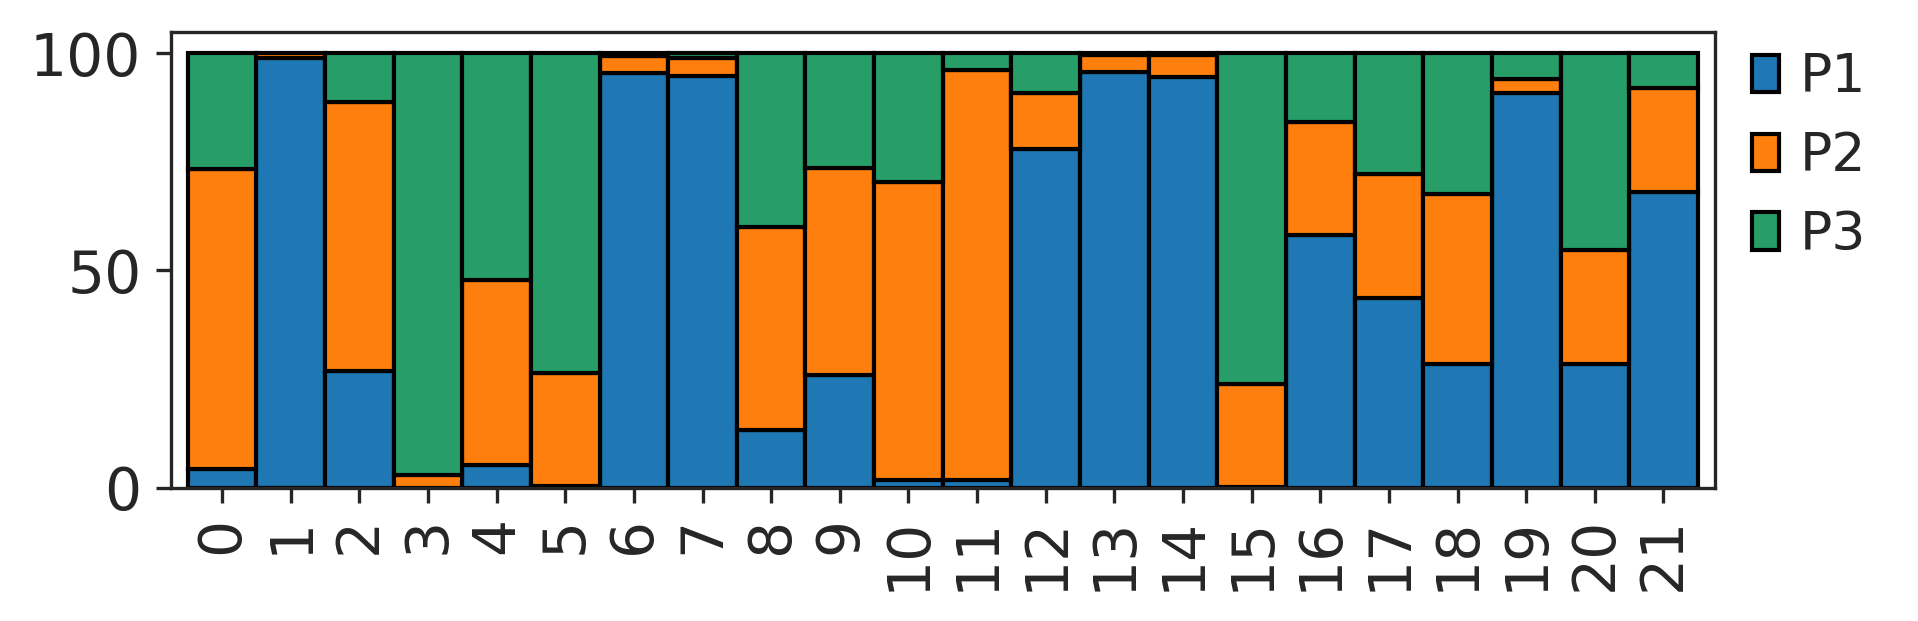

In [96]:
barplot(adata=adata_nocorr, cluster_key="leiden", batch_key="donor")

Batch correlation loss metric: 20.46686777910652


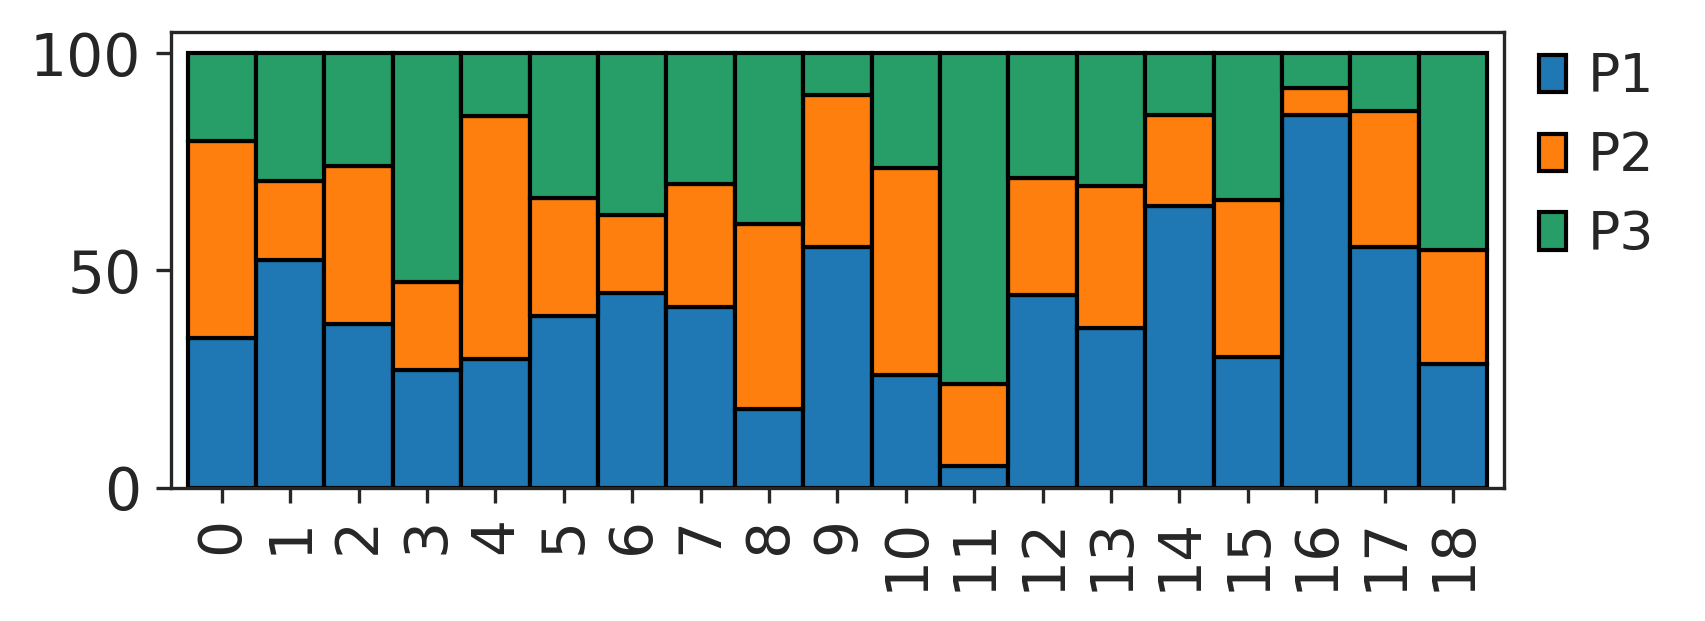

In [94]:
barplot(adata=adata_harmony, cluster_key="leiden", batch_key="donor")

Итог: метрика на выбранных AnnData работает